In [27]:
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from io import BytesIO
from PIL import Image
import maintools as tools
import os

In [28]:
def plot_to_image(frame_ids, knee_angles, hip_angles):
    # Criar o gráfico em um buffer de memória
    fig, ax = plt.subplots(figsize=(10, 5))  # Definir o tamanho do gráfico
    
    # Plotar os ângulos com aumento da grossura da linha
    ax.plot(frame_ids, knee_angles, label="Ângulo do Joelho", color="k", linewidth=5)
    ax.plot(frame_ids, hip_angles, label="Ângulo do Quadril", color="red", linewidth=5)

    # Definir o fundo da figura como preto com alpha 0.5
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.5)
    
    # Definir o fundo dos eixos (área do gráfico) como preto
    ax.set_facecolor('white')
    # Definir limites dos eixos
    ax.set_xlim(0, max(frame_ids) + 10)
    ax.set_ylim(0, 180)
    
    # Definir rótulos e aumentar o tamanho da fonte
    ax.set_xlabel("Frame", fontsize=20)
    ax.set_ylabel("Ângulo (graus)", fontsize=20)
    ax.legend(loc='upper right', fontsize=20)  # Aumentar o tamanho da fonte da legenda
    
    # Adicionar título ao gráfico com fonte maior
    ax.set_title("Ângulos do Joelho e Quadril ao longo dos Frames", fontsize=22)

    # Salvar o gráfico em um buffer de memória com fundo transparente
    buf = BytesIO()
    plt.savefig(buf, format="png", transparent=True)
    buf.seek(0)
    
    # Abrir a imagem com PIL e converter para numpy array
    img_pil = Image.open(buf)
    img_cv = np.array(img_pil)
    
    # Fechar o buffer e a figura
    buf.close()
    plt.close(fig)
    
    # Converter a imagem RGB para BGR (OpenCV usa BGR)
    img_bgr = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
    
    return img_bgr


In [29]:
def process_video_graph(video_path, side='d', output_path=None, show=False):
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils

    # Carregar o vídeo
    cap = cv2.VideoCapture(video_path)

    # Definir codec e criar VideoWriter para salvar o vídeo com ffmpeg
    if output_path: 
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Listas para armazenar os ângulos do quadril e joelho
    hip_angles = []
    knee_angles = []
    frame_ids = []

    with mp_pose.Pose(min_detection_confidence=0.1, min_tracking_confidence=0.1) as pose:
        frame_id = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Recolor para RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            
            # Processar a imagem para detecção de poses
            results = pose.process(image)
            
            # Recolor de volta para BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extrair landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                if side == 'd': 
                    # Coordenadas do quadril, joelho e tornozelo direito
                    hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
                    knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
                    ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
                    shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

                elif side == 'e':
                    # Coordenadas do quadril, joelho e tornozelo esquerdo
                    hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
                    knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
                    ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
                    shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]

                else:
                    raise ValueError("O valor de 'side' precisa ser 'd' (direito) ou 'e' (esquerdo).")
                
                # Cálculo dos ângulos
                angle_knee = tools.calculate_angle(hip, knee, ankle)  # Ângulo do joelho
                angle_hip = tools.calculate_angle(shoulder, hip, knee)  # Ângulo do quadril
                angle_hip = 180 - angle_hip
                angle_knee = 180 - angle_knee

                # Armazenar ângulos
                knee_angles.append(angle_knee)
                hip_angles.append(angle_hip)
                frame_ids.append(frame_id)

                # Exibir os ângulos calculados no vídeo
                cv2.putText(image, f'Joelho: {round(angle_knee, 2)}', 
                            tuple(np.multiply(knee, [frame_width, frame_height]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

                cv2.putText(image, f'Quadril: {round(angle_hip, 2)}', 
                            tuple(np.multiply(hip, [frame_width, frame_height]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
                
                # Renderizar landmarks e conexões no vídeo
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                            mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=4, circle_radius=2),
                                            mp_drawing.DrawingSpec(color=(203, 17, 17), thickness=8, circle_radius=2))
                
            except:
                pass
            
            # Gerar o gráfico e adicioná-lo ao frame
            graph_img = plot_to_image(frame_ids, knee_angles, hip_angles)
            graph_height, graph_width, _ = graph_img.shape

            # Redimensionar o gráfico, se necessário
            scale_factor = 0.3  # Definir o fator de escala
            graph_img = cv2.resize(graph_img, (int(graph_width * scale_factor), int(graph_height * scale_factor)))

            # Inserir o gráfico no canto superior esquerdo do frame de vídeo
            x_offset, y_offset = 10, 10  # Posição do gráfico no frame
            image[y_offset:y_offset + graph_img.shape[0], x_offset:x_offset + graph_img.shape[1]] = graph_img

            # Escrever o frame no vídeo de saída
            if output_path:
                out.write(image)
            
            # Exibir o vídeo (opcional)
            if show is True:
                cv2.imshow('Mediapipe Feed', image)
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
            
            frame_id += 1

    if output_path: 
        cap.release()
        out.release()
    
    if show is True:
        cv2.destroyAllWindows()

    # Criar um DataFrame com os ângulos do quadril e joelho e os ids dos frames
    df = pd.DataFrame({'Frame': frame_ids, 'Knee_Angle': knee_angles, 'Hip_Angle': hip_angles})

    return df

In [30]:
def run_markerless(video_path, side='d', save=True):
    # Get the base name without extension
    main_name = os.path.splitext(os.path.basename(video_path))[0]

    # Extract the folder name from the video path
    folder = os.path.basename(os.path.dirname(video_path))
    res_folder = f'results_{folder}/{main_name}'
    
    # Ensure that the directory exists
    os.makedirs(res_folder, exist_ok=True)
    
    print(f"Saving results to: {res_folder}")
    
    # Define the output paths
    output_vid = os.path.join(res_folder, f'{main_name}_markerless_{side}.mp4')
    output_fig = os.path.join(res_folder, f'{main_name}_markerless_{side}.jpg')
    output_df = os.path.join(res_folder, f'{main_name}_markerless_{side}.csv')
    
    # Process the video and save results
    print(video_path)
    df_angles = process_video_graph(video_path, side=side, output_path=output_vid, show=True)
    print(df_angles)
    if save is True:
        print(output_df) 
        df_angles.to_csv(output_df, index=False)
    
    # Plot and save the angles
    tools.plot_angle(df_angles, save=True, output=output_fig)

Saving results to: results_video/video_teste
video/video_teste.mp4


KeyboardInterrupt: 

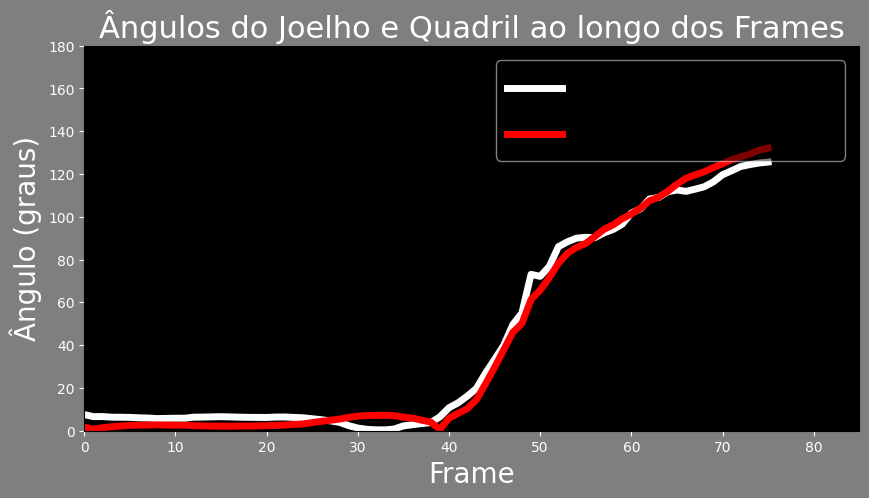

In [31]:
cam = 5
trial = 2
side = 'd'
# video_path = f'D:/editados/0{cam}/bis_0{cam}_s{trial}_t1{side}.mp4'
video_path = f'video/video_teste.mp4'

run_markerless(video_path, side='d')
